In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

In [7]:
df = pd.read_excel('../NLP Preprocessing/02_Resources/Climate_change_links.xlsx')
data = df[["VideoID", "Effectiveness"]]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,1.0
1,eRLJscAlk1M,5.0
2,VbiRNT_gWUQ,2.0
3,5dVcn8NjbwY,NaN
4,5scez5dqtAc,4.0
...,...,...
186,TZ0j6kr4ZJ0,3.0
187,8DiWzvE52ZY,1.0
188,OwqIy8Ikv-c,2.0
189,lPgZfhnCAdI,1.0


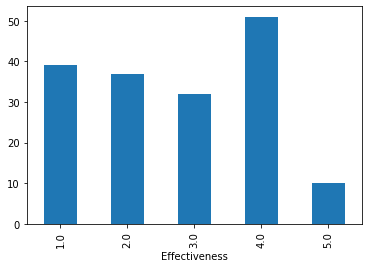

In [8]:
def plot_data(label):
    data.groupby(label).VideoID.count().plot.bar(ylim=0)
    plt.show()
    
# visulaise 
plot_data('Effectiveness')

In [9]:
# clean data
data = data.loc[(data["Effectiveness"] == 1) | (data["Effectiveness"] == 2) | (data["Effectiveness"] == 3) | (data["Effectiveness"] == 4) | (data["Effectiveness"] == 5)]
data = data.reset_index()
del data["index"]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,1.0
1,eRLJscAlk1M,5.0
2,VbiRNT_gWUQ,2.0
3,5scez5dqtAc,4.0
4,JDcro7dPqpA,2.0
...,...,...
164,TZ0j6kr4ZJ0,3.0
165,8DiWzvE52ZY,1.0
166,OwqIy8Ikv-c,2.0
167,lPgZfhnCAdI,1.0


In [10]:
## Custom encoder
def custom_encoder(df):
    df.replace(to_replace = 1.0, value = "neg", inplace=True)
    df.replace(to_replace = 2.0, value = "neg", inplace=True)
    df.replace(to_replace = 4.0, value = "pos", inplace=True)
    df.replace(to_replace = 5.0, value = "pos", inplace=True)

custom_encoder(df['Effectiveness'])

data = df[["VideoID", "Effectiveness"]]
data = data[data["Effectiveness"] != 3]
data = data.loc[(data["Effectiveness"] == 'pos') | (data["Effectiveness"] == 'neg')]
data = data.reset_index()
del data["index"]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,neg
1,eRLJscAlk1M,pos
2,VbiRNT_gWUQ,neg
3,5scez5dqtAc,pos
4,JDcro7dPqpA,neg
...,...,...
132,JYZpxRy5Mfg,pos
133,xXMlFFY9uEI,pos
134,8DiWzvE52ZY,neg
135,OwqIy8Ikv-c,neg


In [11]:
# get documnets (pre-processd comments)
documents = []
for i in range(len(data)):
    VideoID = data["VideoID"][i]
    comment = pd.read_csv("../NLP Preprocessing/03_Processed_Comments/"+VideoID+"/"+VideoID+"_all_words.csv")
    documents.append(list(comment["0"]))

In [12]:
# create two new columns of the pre-processed data in list and string form
data['cleaned'] = documents
data['cleaned_string'] = [' '.join(map(str, l)) for l in data['cleaned']]

In [13]:
# function to plot confusion matrix
def plot_conf_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.2)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [16]:
# split training and test set
X = data.cleaned_string
y = data.Effectiveness
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier()),
                   ])

# Set grid search params
grid_params_knn = [{'clf__n_neighbors': [4, 5, 6],
                    'clf__p': [1, 2]
                  }]

KNN = GridSearchCV(estimator=pipe_knn,
                   param_grid=grid_params_knn,
                   scoring='accuracy',
                   cv=3) 

In [11]:
# List of pipelines for iterating through each of them
grids = [KNN]

# Creating a dict for our reference
grid_dict = {0: 'KNeighborsClassifier'}

# Fit the grid search objects
print('Performing model optimizations...')

best_acc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    
    gs.fit(X_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: KNeighborsClassifier
Best params are : {'clf__n_neighbors': 4, 'clf__p': 2}
Best training accuracy: 0.559
Test set accuracy score for best params: 0.571 

Classifier with best test set accuracy: KNeighborsClassifier
